<a href="https://colab.research.google.com/github/EdgarTriquet/PySpark-Projects/blob/main/AirBnB_paris_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting the Price of Airbnb in Paris




## Préparation

Pour accéder directement aux fichiers stockées sur le google drive. Renseigner le code d'authentification lorsqu'il est demandé

Ajuster le nom de votre dossier : MyDrive/ens/bdle/dir. **Remplacer dir **

In [7]:
import os
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

drive_dir = "/content/drive/MyDrive/ens/bdle/dir"
os.makedirs(drive_dir, exist_ok=True)
os.listdir(drive_dir)

Mounted at /content/drive


[]

Installer pyspark et findspark :


In [ ]:
!pip install -q pyspark
!pip install -q findspark

     |████████████████████████████████| 281.3 MB 28 kB/s 
     |████████████████████████████████| 198 kB 43.5 MB/s 


Démarrer la session spark

In [8]:
import os
# !find /usr/local -name "pyspark"
os.environ["SPARK_HOME"] = "/usr/local/lib/python3.7/dist-packages/pyspark"
os.environ["JAVA_HOME"] = "/usr"

In [9]:
# Principaux import
import findspark
from pyspark.sql import SparkSession 
from pyspark import SparkConf  

# pour les dataframe et udf
from pyspark.sql import *  
from pyspark.sql.functions import *
from pyspark.sql.types import *
from datetime import *

# pour le chronomètre
import time

# initialise les variables d'environnement pour spark
findspark.init()

# Démarrage session spark 
# --------------------------
def demarrer_spark():
  local = "local[*]"
  appName = "TP"
  configLocale = SparkConf().setAppName(appName).setMaster(local).\
  set("spark.executor.memory", "6G").\
  set("spark.driver.memory","6G").\
  set("spark.sql.catalogImplementation","in-memory")
  
  spark = SparkSession.builder.config(conf = configLocale).getOrCreate()
  sc = spark.sparkContext
  sc.setLogLevel("ERROR")
  
  spark.conf.set("spark.sql.autoBroadcastJoinThreshold","-1")

  # On ajuste l'environnement d'exécution des requêtes à la taille du cluster (4 coeurs)
  spark.conf.set("spark.sql.shuffle.partitions","4")    
  print("session démarrée, son id est ", sc.applicationId)
  return spark
spark = demarrer_spark()

session démarrée, son id est  local-1635850143664


In [10]:
# on utilise 8 partitions au lieu de 200 par défaut
spark.conf.set("spark.sql.shuffle.partitions", "8")
print("Nombre de partitions utilisées : ", spark.conf.get("spark.sql.shuffle.partitions"))

Nombre de partitions utilisées :  8


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data loading

In [12]:
from google.colab import files
#upload to session storage the cvs file
files.download('listings_summary.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
df = spark.read.option("header", "true").csv('listings_summary.csv')

In [14]:
#Get the shape of the dataFrame
print((df.count(), len(df.columns)))


(50236, 18)


In [15]:
df.columns

['id',
 'name',
 'host_id',
 'host_name',
 'neighbourhood_group',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'last_review',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'number_of_reviews_ltm',
 'license']

In [16]:
df.show(5)

+----+--------------------+-------+----------+-------------------+--------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------------------+--------------------+
|  id|                name|host_id| host_name|neighbourhood_group| neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|number_of_reviews_ltm|             license|
+----+--------------------+-------+----------+-------------------+--------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------------------+--------------------+
|5396|Explore the heart...|   7903|    Borzou|               null|Hôtel-de-Ville|48.85247|  2.35835|Entire home/apt|  110|             2|              260| 2020-08-08|  

Several columns seem to be unrelevant for our task so I decided to drop them from the database

In [17]:
df = df.drop("license", "id", "name", "host_name", "host_id", "longitude", "latitude")

Let's have a look at what are the data type

In [18]:
df.printSchema()

root
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: string (nullable = true)
 |-- minimum_nights: string (nullable = true)
 |-- number_of_reviews: string (nullable = true)
 |-- last_review: string (nullable = true)
 |-- reviews_per_month: string (nullable = true)
 |-- calculated_host_listings_count: string (nullable = true)
 |-- availability_365: string (nullable = true)
 |-- number_of_reviews_ltm: string (nullable = true)



We need to change the dataTypes of some fields in order to analyse them


In [19]:
df = df.select(df.neighbourhood,
df.room_type,
df.minimum_nights.cast("int"),
df.number_of_reviews.cast("int"),
df.last_review.cast("date"),
df.reviews_per_month.cast("int"),
df.calculated_host_listings_count.cast("int"),
df.availability_365.cast("int"),
df.number_of_reviews_ltm.cast("int"),
df.price.cast("int")
)

Let's check if there are null values in the dataset 

In [20]:
for col in df.columns:
  print(col, "\t", "with null values: ", df.filter(df[col].isNull()).count())

neighbourhood 	 with null values:  118
room_type 	 with null values:  106
minimum_nights 	 with null values:  107
number_of_reviews 	 with null values:  198
last_review 	 with null values:  11614
reviews_per_month 	 with null values:  11515
calculated_host_listings_count 	 with null values:  109
availability_365 	 with null values:  105
number_of_reviews_ltm 	 with null values:  199
price 	 with null values:  120


With those information, we can add modification to the dataset :

*   neighbourhood_group is always null so we drop it
*   replace number_of_review, number_of_reviews_ltm and reviews_per_month null fields by zero 
*   replace last_review null field by the oldest date

In order to perform well a decision tree algorithm, we need to only have string and int value. We chosed to replace the date of the last review with the number of day since the last review. It keeps the same information.

In [21]:
df = df.drop("neighbourhood_group")
min_date = df.select(min(df.last_review).cast("string")).first()[0]#the date will be converted automatically with the na.fill function
df = df.na.fill({'last_review': min_date, 'neighbourhood': 'unknown', 'reviews_per_month': 0, 'number_of_reviews_ltm': 0, 'room_type': 'unknown', 'number_of_reviews': 0})##Problem null value is considered as string.
df = df.na.drop()#drop rows where it remains null value
df = df.withColumn('date_diff', datediff(current_date(),df.last_review)) 
df = df.drop('last_review')

print((df.count(), len(df.columns)))

(50112, 10)


Let's set up some baselines in order to evaluate our future model.
The first simple model can be to predict the mean price for every room.

In [22]:
df.select(df.price.alias('prices')).describe().show()

+-------+------------------+
|summary|            prices|
+-------+------------------+
|  count|             50112|
|   mean|125.91143837803321|
| stddev|218.81595819082617|
|    min|                 0|
|    max|             11600|
+-------+------------------+



In [23]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

price_list=[data[0] for data in df.
       select('price').collect()]
mean = np.mean(price_list)

mean_price = df.select(df.price).count()*[mean]
print("MAE = ",mean_absolute_error(price_list, mean_price))
print("RMSE = ", np.sqrt(mean_squared_error(price_list, mean_price)))


MAE =  76.51989046610942
RMSE =  218.81377491087522


The vast majority of prices are under 300€. The prices above this can be considered as outliers to remove them.

{'boxes': [<matplotlib.lines.Line2D at 0x7fc016e16210>],
 'caps': [<matplotlib.lines.Line2D at 0x7fc016e2c2d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fc016e06790>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fc016e2cd90>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fc016e16810>,
  <matplotlib.lines.Line2D at 0x7fc016e16d50>]}

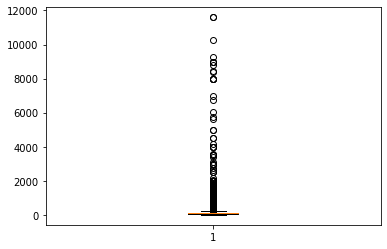

In [24]:
import matplotlib.pyplot as plt

plt.boxplot(price_list)

I decided to remove all the rows where the price was higher than 500€ per night 

In [27]:
from pyspark.sql.functions import when
df_filt = df.withColumn('Result',when(df.price<=300,"True")).filter("Result==True").drop("Result")
price_list_filt=[data[0] for data in df_filt.
       select('price').collect()]

{'boxes': [<matplotlib.lines.Line2D at 0x7fc016d46190>],
 'caps': [<matplotlib.lines.Line2D at 0x7fc016d4c1d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fc016d56210>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fc016d4cc90>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fc016d46710>,
  <matplotlib.lines.Line2D at 0x7fc016d46c50>]}

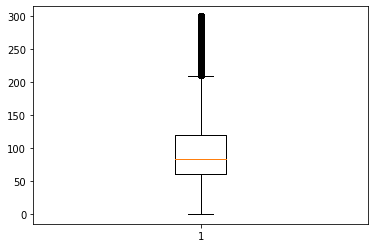

In [28]:
plt.boxplot(price_list_filt)

In [29]:
price_list_filt=[data[0] for data in df_filt.
       select('price').collect()]
mean = np.mean(price_list)

mean_price = df_filt.select(df_filt.price).count()*[mean]
print("MAE filt= ",mean_absolute_error(price_list_filt, mean_price))
print("RMSE filt= ", np.sqrt(mean_squared_error(price_list_filt, mean_price)))

MAE filt=  54.00050645717992
RMSE filt=  62.793054651681636


The MAE hasn't changed much, but the RMSE is significantly improved, it's logical because RMSE emphasized the huge difference because of the square.

## Pipeline

In [30]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import VectorIndexer
df = df_filt
col_int = []
col_str = []
for col in df.dtypes:
  data_type = col[1]
  if data_type == "string":
    col_str.append(col[0])
  elif data_type == "int":
    col_int.append(col[0])


label = 'price'
prefix = 'indexed_'

col_str_indexed = list(map(lambda c:prefix+c, col_str))
col_int.remove(label)
features_col = col_str_indexed + col_int


features_string_indexer = StringIndexer(inputCols=col_str,outputCols=col_str_indexed)#transform string value to index

vec_assembler = VectorAssembler(inputCols= features_col,outputCol= 'vector')

vec_indexer = VectorIndexer(inputCol='vector',outputCol='features' ,maxCategories=25)


stages = [features_string_indexer,vec_assembler,vec_indexer] # stages of the pipeline

from pyspark.ml import Pipeline 

pipeline = Pipeline(stages = stages)
train_data = pipeline.fit(df).transform(df).select("features",label)
train_data.show(5)

+--------------------+-----+
|            features|price|
+--------------------+-----+
|[15.0,0.0,2.0,260...|  110|
|[15.0,0.0,10.0,27...|  100|
|[7.0,0.0,6.0,6.0,...|  130|
|[19.0,0.0,180.0,0...|   75|
|[1.0,0.0,4.0,31.0...|   80|
+--------------------+-----+
only showing top 5 rows



In [31]:
train_data.select(train_data.features).first()

Row(features=DenseVector([15.0, 0.0, 2.0, 260.0, 2.0, 1.0, 29.0, 35.0, 451.0]))

## Decision Tree

In [34]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol='features', labelCol='price', maxBins=85)


In [35]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

evaluatorR= RegressionEvaluator(labelCol='price',metricName='rmse')

dt_paramGrid = ParamGridBuilder().addGrid(dt.minInstancesPerNode, [10,50,100]).addGrid(dt.maxDepth, [5,15]) .build()


In [36]:
#create k folds with k=3.
cv = CrossValidator(estimator=dt, estimatorParamMaps=dt_paramGrid, evaluator=evaluatorR, numFolds=3, parallelism=2, seed=2)

cvModel = cv.fit(train_data)

bestModel = cvModel.bestModel

print(bestModel)
print(cvModel.avgMetrics)

DecisionTreeRegressionModel: uid=DecisionTreeRegressor_e9c77a092b84, depth=15, numNodes=1283, numFeatures=9
[48.36025734885075, 49.1233361719254, 48.35968360668758, 47.55263291305716, 48.416061685123054, 47.556376632694594]


Our model seems bad but it is still better than predicting the mean price. To improve it, we can extract some key word from the description.